# Prevendo o nível de poluição do Ar da China (2010 - 2014)
### Para isso iremos utilizar uma Rede Neural Recorrente LSTM

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
base = pd.read_csv("poluicao.csv")

In [3]:
base.shape

(43824, 13)

In [4]:
base = base.dropna()

In [5]:
base.shape

(41757, 13)

In [6]:
base.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [7]:
base = base.drop(columns=["No", "year", "day", "month", "hour", "cbwd"])

In [8]:
base.head()

,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,129.0,-16,-4.0,1020.0,1.79,0,0
25,148.0,-15,-4.0,1020.0,2.68,0,0
26,159.0,-11,-5.0,1021.0,3.57,0,0
27,181.0,-7,-5.0,1022.0,5.36,1,0
28,138.0,-7,-5.0,1022.0,6.25,2,0


In [9]:
base.shape

(41757, 7)

# Separando a base de traino e a base de teste

In [10]:
base_train = base.iloc[:27977, :]

### Bse de dados de treinamento

In [11]:
base_train.shape

(27977, 7)

### Bse de dados de teste

# Pré-Processamento dos dados de traino
Nessa etapa, vamos colocar os dados de trainamento no formato adquado para ser processado por uma Rede Neural Recorrente

In [13]:
base_train = base_train.iloc[:, :].values
base_train.shape

(27977, 7)

In [14]:
# Normalizando os atributos previsores
normalizador = MinMaxScaler(feature_range=(0, 1))
base_train_norm = normalizador.fit_transform(base_train)

## Colocando os dados no formato correto para uma RNN

In [15]:
previsores = []
pm2_5_real = []
for i in range(50, 27977):
    previsores.append(base_train_norm[i-50:i, 0:8])
    pm2_5_real.append(base_train_norm[i, 0])
previsores, pm2_5_real = np.array(previsores), np.array(pm2_5_real)

In [16]:
previsores.shape

(27927, 50, 7)

In [17]:
pm2_5_real.shape

(27927,)

# Criando o modelo LSTM utilizando o keras

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [19]:
regressor = Sequential()

regressor.add(LSTM(units=100, return_sequences = True, input_shape = (previsores.shape[1], 7)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = "linear"))

regressor.compile(optimizer = "rmsprop", loss = "mean_squared_error",
                 metrics = ["mean_absolute_error"])

In [20]:
# Essa classe do keras monitora uma métrica do modelo, caso essa métrica pare de melhorar por uma quantidade
# de etapas pré definidas, o modelo para o treinamento

es = EarlyStopping(monitor="loss", min_delta=1e-10, patience=10, verbose=1)

# -------
rlr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, verbose=1)

mcp = ModelCheckpoint(filepath="pesos_poluicao.h5", monitor="loss", save_best_only=True)


In [21]:
regressor.fit(previsores, pm2_5_real, epochs=100, batch_size=32,
             callbacks=[es, rlr, mcp])

Epoch 1/100
873/873 [==============================] - 135s 143ms/step - loss: 0.0076 - mean_absolute_error: 0.0551
Epoch 2/100
873/873 [==============================] - 130s 148ms/step - loss: 0.0016 - mean_absolute_error: 0.0268
Epoch 3/100
873/873 [==============================] - 173s 197ms/step - loss: 0.0011 - mean_absolute_error: 0.0221
Epoch 4/100
873/873 [==============================] - 149s 171ms/step - loss: 9.6227e-04 - mean_absolute_error: 0.0206
Epoch 5/100
873/873 [==============================] - 122s 140ms/step - loss: 8.8935e-04 - mean_absolute_error: 0.0198
Epoch 6/100
873/873 [==============================] - 122s 140ms/step - loss: 8.4469e-04 - mean_absolute_error: 0.0190
Epoch 7/100
873/873 [==============================] - 122s 140ms/step - loss: 9.1880e-04 - mean_absolute_error: 0.0189
Epoch 8/100
873/873 [==============================] - 123s 141ms/step - loss: 8.4275e-04 - mean_absolute_error: 0.0186
Epoch 9/100
873/873 [==============================]

# Pré processamento da base de teste

In [37]:
entradas = base[27927:].values

# Valores de pm2.5 de teste
pm2_5_real_test = base.iloc[27977:, 0:1].values

In [38]:
len(pm2_5_real_test)

13780

In [24]:
entradas = normalizador.transform(entradas)

In [26]:
x_teste = []
for i in range(50, 13830):
    x_teste.append(entradas[i-50:i, 0:8])
x_teste = np.array(x_teste)


In [27]:
x_teste.shape

(13780, 50, 7)

In [30]:
normalizador_previsoes = MinMaxScaler(feature_range=(0, 1))
normalizador_previsoes.fit_transform(base_train[:, 0:1])

array([[0.12977867],
       [0.14889336],
       [0.15995976],
       ...,
       [0.07142857],
       [0.06539235],
       [0.03722334]])

# Fazendo as previsões

In [31]:
previsoes = regressor.predict(x_teste)
previsoes = normalizador_previsoes.inverse_transform(previsoes)

In [32]:
previsoes.mean()

95.278595

In [39]:
pm2_5_real_test.mean()

94.75616835994194

# Gráfico das previsões e dos valores reais

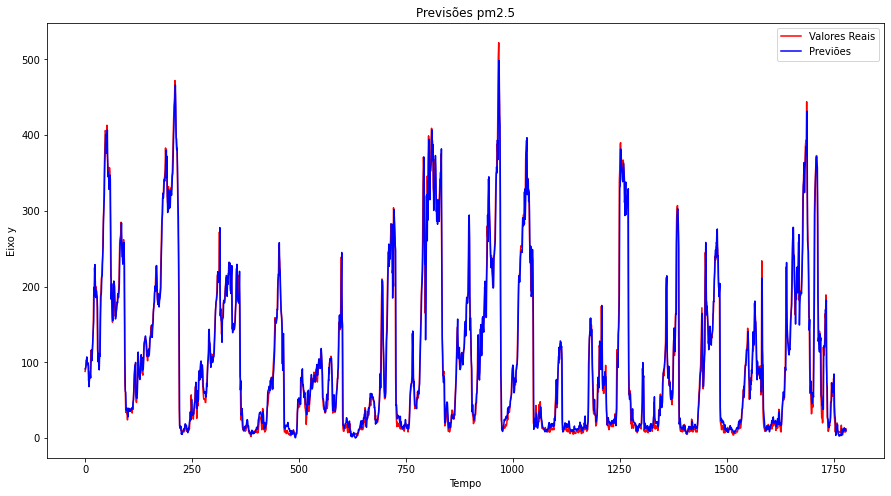

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.plot(pm2_5_real_test[12000:], color="red", label="Valores Reais")
plt.plot(previsoes[12000:], color="blue", label="Previões")
plt.title("Previsões pm2.5")
plt.xlabel("Tempo")
plt.ylabel("Eixo y")
plt.legend()
plt.show()